# Demonstrating PySpark

This PySpark shell was run with the following command

```
/Users/ianmilligan1/dropbox/git/spark-2.1.1-bin-hadoop2.6/bin/pyspark --driver-class-path /Users/ianmilligan1/dropbox/git/aut/target --jars /Users/ianmilligan1/dropbox/git/aut/target/aut-0.16.1-SNAPSHOT-fatjar.jar
```

In the `/aut/src/main/python` directory (in order to find the `aut` library import).

This needs to used with the most recent version of AUT. To do so, you need to follow the build instructions in the [AUT repository](https://github.com/archivesunleashed/aut).

## Getting Started

The next few lines set a sample directory, and import files, and then let us see the Schema. It then goes through the basic DataFrame options, from domain counting to extracting pages to looking at hyperlinks.

In [1]:
warcs="/Users/ianmilligan1/dropbox/git/aut-resources/Sample-Data/*.warc.gz"

In [2]:
from aut import *

In [4]:
archive = WebArchive(sc, sqlContext, warcs)

pages = archive.pages()
pages.printSchema()

pages.select(extract_domain("Url").alias("Domain")) \
    .groupBy("Domain").count().orderBy("count", ascending=False).show()

links = archive.links()
links.printSchema()

links.select(extract_domain("Src").alias("SrcDomain"), extract_domain("Dest").alias("DestDomain")) \
    .groupBy("SrcDomain", "DestDomain").count().orderBy("count", ascending=False).show()

root
 |-- CrawlDate: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- MimeType: string (nullable = true)
 |-- Content: string (nullable = true)

+--------------------+-----+
|              Domain|count|
+--------------------+-----+
|       equalvoice.ca| 4629|
|          liberal.ca| 1968|
|       greenparty.ca|  693|
|policyalternative...|  584|
|         fairvote.ca|  465|
|              ndp.ca|  415|
|     davidsuzuki.org|  362|
|     canadiancrc.com|   83|
|         youtube.com|    8|
|v7.lscache3.c.you...|    1|
|              gca.ca|    1|
|v18.lscache5.c.yo...|    1|
|   communitywalk.com|    1|
|          flickr.com|    1|
+--------------------+-----+

root
 |-- CrawlDate: string (nullable = true)
 |-- Src: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Anchor: string (nullable = true)

+---------------+--------------------+------+
|      SrcDomain|          DestDomain| count|
+---------------+--------------------+------+
|     liberal.ca|     

In [5]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

jvm = sc._jvm
loader = jvm.io.archivesunleashed.DataFrameLoader(sc._jsc.sc())

def extract_domain(url):
  url = url.replace('http://', '').replace('https://', '')
  if '/' in url:
    return url.split('/')[0].replace('www.', '')
  else:
    return url.replace('www.', '')

sqlContext.udf.register("extract_domain", extract_domain, StringType())
extract_domain_udf = udf(extract_domain, StringType())


In [6]:
pages = DataFrame(loader.extractValidPages("/Users/ianmilligan1/dropbox/git/aut-resources/Sample-Data/*.warc.gz"), sqlContext)

In [7]:
pages.printSchema()


root
 |-- CrawlDate: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- MimeType: string (nullable = true)
 |-- Content: string (nullable = true)



In [8]:
pages.select(extract_domain_udf("Url").alias("Domain")) \
  .groupBy("Domain").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|              Domain|count|
+--------------------+-----+
|       equalvoice.ca| 4629|
|          liberal.ca| 1968|
|       greenparty.ca|  693|
|policyalternative...|  584|
|         fairvote.ca|  465|
|              ndp.ca|  415|
|     davidsuzuki.org|  362|
|     canadiancrc.com|   83|
|         youtube.com|    8|
|              gca.ca|    1|
|v7.lscache3.c.you...|    1|
|v18.lscache5.c.yo...|    1|
|          flickr.com|    1|
|   communitywalk.com|    1|
+--------------------+-----+



In [9]:
links = DataFrame(loader.extractHyperlinks(warcs), sqlContext)

In [10]:
links.printSchema()

root
 |-- CrawlDate: string (nullable = true)
 |-- Src: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Anchor: string (nullable = true)



In [11]:
links.select(extract_domain_udf("Src").alias("SrcDomain"), extract_domain_udf("Dest").alias("DestDomain")) \
  .groupBy("SrcDomain", "DestDomain").count().orderBy("count", ascending=False).show()

+---------------+--------------------+------+
|      SrcDomain|          DestDomain| count|
+---------------+--------------------+------+
|     liberal.ca|          liberal.ca|103668|
|  equalvoice.ca|       equalvoice.ca| 17036|
|         ndp.ca|              ndp.ca| 15311|
|davidsuzuki.org|     davidsuzuki.org| 13903|
|  greenparty.ca|       greenparty.ca|  9715|
|  equalvoice.ca|gettingtothegate.com|  4259|
|  equalvoice.ca|       snapdesign.ca|  4259|
|  equalvoice.ca|         thestar.com|  4259|
|     liberal.ca|         twitter.com|  3936|
|canadiancrc.com|translate.google.com|  2584|
|     liberal.ca|             plcq.ca|  1968|
|     liberal.ca|        facebook.com|  1968|
|     liberal.ca|      liberal.nf.net|  1968|
|     liberal.ca|   liberalalberta.ca|  1968|
|     liberal.ca|           lpcbc.com|  1968|
|     liberal.ca|       liberal.ns.ca|  1968|
|     liberal.ca|liberalpartyofcan...|  1968|
|     liberal.ca|         nblib.nb.ca|  1968|
|     liberal.ca|      pei.liberal

## Now let's do Pandas

The next set of commands takes the data into Pandas and then begins to leverage that library to visualize things.

In [12]:
pdf=links.select(extract_domain_udf("Src").alias("SrcDomain"), extract_domain_udf("Dest").alias("DestDomain")) \
  .groupBy("SrcDomain", "DestDomain").count().orderBy("count", ascending=False).toPandas()

In [13]:
pdf.head()

,SrcDomain,DestDomain,count
0,liberal.ca,liberal.ca,103668
1,equalvoice.ca,equalvoice.ca,17036
2,ndp.ca,ndp.ca,15311
3,davidsuzuki.org,davidsuzuki.org,13903
4,greenparty.ca,greenparty.ca,9715


In [14]:
freq=pages.select(extract_domain_udf("Url").alias("Domain")) \
  .groupBy("Domain").count().orderBy("count", ascending=False).toPandas()

In [15]:
freq.head()


,Domain,count
0,equalvoice.ca,4629
1,liberal.ca,1968
2,greenparty.ca,693
3,policyalternatives.ca,584
4,fairvote.ca,465


In [16]:
%matplotlib inline
import matplotlib


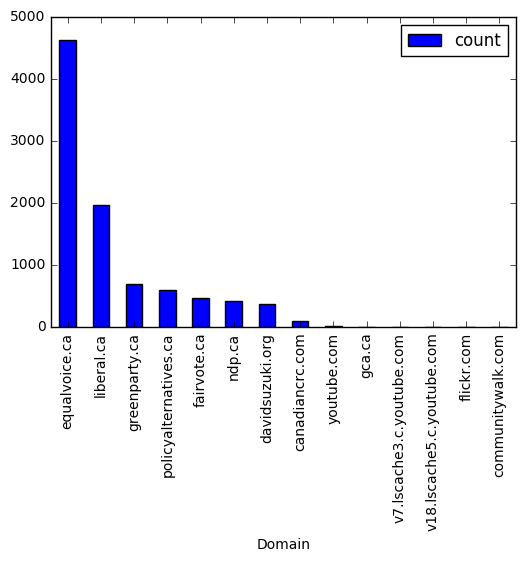

In [17]:
freq.plot(x='Domain', kind='bar')


In [18]:
import networkx as nx


In [19]:
pdf.head()


,SrcDomain,DestDomain,count
0,liberal.ca,liberal.ca,103668
1,equalvoice.ca,equalvoice.ca,17036
2,ndp.ca,ndp.ca,15311
3,davidsuzuki.org,davidsuzuki.org,13903
4,greenparty.ca,greenparty.ca,9715


In [20]:
graph=nx.from_pandas_dataframe(pdf,source='SrcDomain',target='DestDomain')


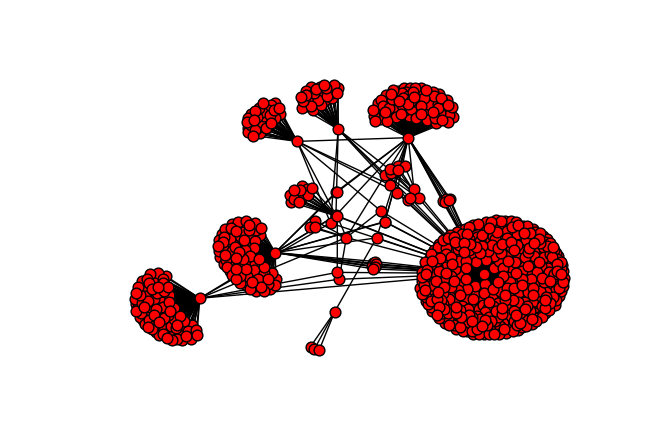

In [21]:
nx.draw(graph, layout=nx.spring_layout(graph),node_size=60,font_size=8)
